<a href="https://colab.research.google.com/github/LeoMcBills/ML_humanEmotionDetection/blob/main/Human_Emotion_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
# !pip install -q kaggle

In [46]:
# !mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [47]:
# !cp kaggle.json ~/.kaggle/

In [48]:
# !chmod 600 /root/.kaggle/kaggle.json

In [49]:
# !kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

 94% 290M/309M [00:03<00:00, 44.6MB/s]
100% 309M/309M [00:03<00:00, 89.5MB/s]


In [50]:
!unzip "/content/human-emotions-datasethes.zip" -d "/content/datasets"

Streaming output truncated to the last 5000 lines.
  inflating: /content/datasets/EmotionsDataset/data/nothing/720.jpg  
  inflating: /content/datasets/EmotionsDataset/data/nothing/721.jpg  
  inflating: /content/datasets/EmotionsDataset/data/nothing/722.jpg  
  inflating: /content/datasets/EmotionsDataset/data/nothing/723.jpg  
  inflating: /content/datasets/EmotionsDataset/data/nothing/724.jpg  
  inflating: /content/datasets/EmotionsDataset/data/nothing/725.jpg  
  inflating: /content/datasets/EmotionsDataset/data/nothing/726.jpg  
  inflating: /content/datasets/EmotionsDataset/data/nothing/727.jpg  
  inflating: /content/datasets/EmotionsDataset/data/nothing/728.jpg  
  inflating: /content/datasets/EmotionsDataset/data/nothing/729.jpg  
  inflating: /content/datasets/EmotionsDataset/data/nothing/73.jpg  
  inflating: /content/datasets/EmotionsDataset/data/nothing/730.jpg  
  inflating: /content/datasets/EmotionsDataset/data/nothing/731.jpg  
  inflating: /content/datasets/EmotionsD

In [104]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, InputLayer, Flatten, BatchNormalization, Input, Dropout, RandomFlip, RandomRotation, RandomContrast, Resizing, Rescaling
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy,TopKCategoricalAccuracy, CategoricalAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC
import sklearn
import cv2
from sklearn.metrics import confusion_matrix, roc_curve
from tensorflow.keras.losses import CategoricalCrossentropy
import seaborn as sns
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import L2, L1
import albumentations as A
import tensorflow_probability as tfp
from tensorflow.train import Example, Features, Feature, BytesList, FloatList, Int64List

In [105]:
train_directory = "/content/datasets/Emotions Dataset/Emotions Dataset/train"
val_directory = "/content/datasets/Emotions Dataset/Emotions Dataset/test"
CLASS_NAMES = ["angry", "happy", "sad"]

CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 0.001,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 100,
    "N_DENSE_2": 10,
    "NUM_CLASSES": 3,
}

In [106]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99
)

Found 6799 files belonging to 3 classes.


In [107]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99
)

Found 2278 files belonging to 3 classes.


In [108]:
for i in val_dataset.take(1):
  print(i)

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[ 20.        ,  20.        ,  20.        ],
         [ 19.1875    ,  19.1875    ,  19.1875    ],
         [ 19.        ,  19.        ,  19.        ],
         ...,
         [ 29.125     ,  29.125     ,  29.125     ],
         [ 25.        ,  25.        ,  25.        ],
         [ 25.        ,  25.        ,  25.        ]],

        [[ 20.        ,  20.        ,  20.        ],
         [ 19.847656  ,  19.847656  ,  19.847656  ],
         [ 19.8125    ,  19.8125    ,  19.8125    ],
         ...,
         [ 28.820312  ,  28.820312  ,  28.820312  ],
         [ 25.660156  ,  25.660156  ,  25.660156  ],
         [ 25.        ,  25.        ,  25.        ]],

        [[ 20.6875    ,  20.6875    ,  20.6875    ],
         [ 21.246094  ,  21.246094  ,  21.246094  ],
         [ 21.847656  ,  21.847656  ,  21.847656  ],
         ...,
         [ 25.3125    ,  25.3125    ,  25.3125    ],
         [ 22.375     ,  22.375     ,  22.375 

# Dataset Visualization

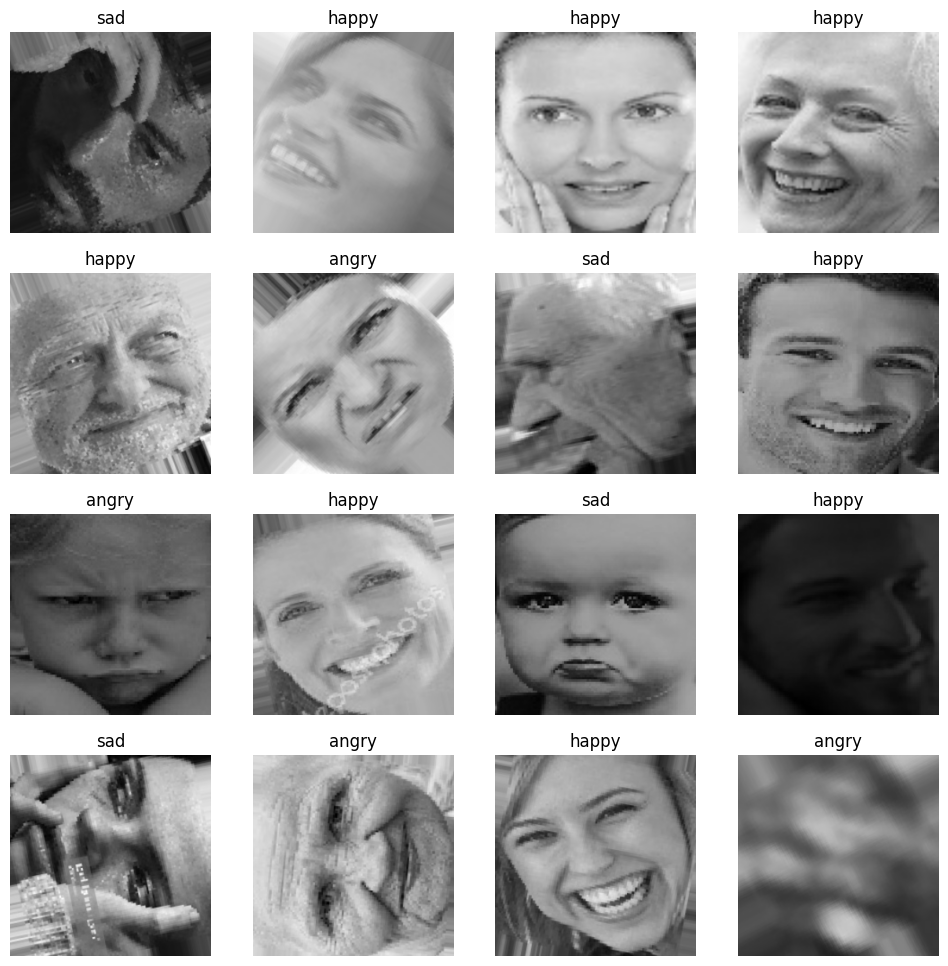

In [189]:
plt.figure(figsize = (12, 12))

for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(images[i]/255.)
    plt.title(CLASS_NAMES[tf.argmax(labels[i], axis = 0).numpy()])
    plt.axis("off")

# Data Augmentation

In [190]:
# tf.keras.layer augment

augment_layers = tf.keras.Sequential([
    RandomRotation(factor = (-0.025, 0.025),),
    RandomFlip(mode='horizontal',),
    RandomContrast(factor=0.1),
])

In [191]:
def augment_layer(image, label):
  return augment_layers(image, training = True), label

cutmix augmentation

In [192]:
def box(lamda):

  r_x = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)
  r_y = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)

  r_w = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)
  r_h = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)

  r_x = tf.clip_by_value(r_x - r_w//2, 0, CONFIGURATION["IM_SIZE"])
  r_y = tf.clip_by_value(r_y - r_h//2, 0, CONFIGURATION["IM_SIZE"])

  x_b_r = tf.clip_by_value(r_x + r_w//2, 0, CONFIGURATION["IM_SIZE"])
  y_b_r = tf.clip_by_value(r_y + r_h//2, 0, CONFIGURATION["IM_SIZE"])

  r_w = x_b_r - r_x
  if(r_w == 0):
    r_w  = 1

  r_h = y_b_r - r_y
  if(r_h == 0):
    r_h = 1

  return r_y, r_x, r_h, r_w

In [193]:
def cutmix(train_dataset_1, train_dataset_2):
  (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(0.2,0.2)
  lamda = lamda.sample(1)[0]

  r_y, r_x, r_h, r_w = box(lamda)
  crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
  pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
  pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  image = image_1 - pad_1 + pad_2

  lamda = tf.cast(1- (r_w*r_h)/(CONFIGURATION["IM_SIZE"]*CONFIGURATION["IM_SIZE"]), dtype = tf.float32)
  label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)

  return image, label

# DATA PREPARATION

In [194]:
train_dataset_1 = train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
train_dataset_2 = train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)

mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

In [195]:
training_dataset = (
    mixed_dataset
    .map(cutmix, num_parallel_calls = tf.data.AUTOTUNE)
    # .prefetch(tf.data.AUTOTUNE)
)

In [196]:
training_dataset

<_ParallelMapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [197]:
# training_dataset = (
#     train_dataset
#     .map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
#     .prefetch(tf.data.AUTOTUNE)
# )

In [198]:
val_dataset = (
    train_dataset
    # .prefetch(tf.data.AUTOTUNE)
)

In [199]:
resize_rescale_layers = tf.keras.Sequential([
    Resizing(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    Rescaling(1./255),
])

#TFRecords

In [200]:
# training_dataset = (
#     training_dataset
#     .unbatch()
# )

In [201]:
# val_dataset = (
#     val_dataset
#     .unbatch()
# )

In [202]:
# training_dataset

In [203]:
# val_dataset

In [204]:
# def create_example(image, label):

#   # label = np.int64(label)

#   bytes_feature = Feature(
#       bytes_list=BytesList(value=[image]))

#   int_feature = Feature(
#       int64_list=Int64List(value=[label]))

#   example = Example(
#       features=Features(feature={
#           'images': bytes_feature,
#           'labels': int_feature,
#       }))
#   return example.SerializeToString()


In [205]:
# NUM_SHARDS = 10
# PATH = 'tfrecords/shard_{:02d}.tfrecord'

In [206]:
# def encode_image(image, label):
#   image = tf.image.convert_image_dtype(image, dtype=tf.uint8)
#   image = tf.io.encode_jpeg(image)
#   return image, label

In [207]:
# # from IPython.utils.py3compat import encode
# encoded_dataset = (
#     training_dataset
#     .map(encode_image)
# )

In [208]:
# for shard_number in range(NUM_SHARDS):

#   sharded_dataset = (
#       encoded_dataset
#       .shard(NUM_SHARDS, shard_number)
#       .as_numpy_iterator()
#   )
#   with tf.io.TFRecordWriter(PATH.format(shard_number)) as file_writer:
#     for encoded_image, encoded_label in sharded_dataset:
#       example = create_example(encoded_image, encoded_label)
#       file_writer.write(example)

In [209]:
# recons_dataset = tf.data.TFRecordDataset(
#     filenames = [PATH.format(p) for p in range(NUM_SHARDS)]
#     )

In [210]:
# l = [PATH.format(p) for p in range(NUM_SHARDS)]
# print(l)

In [211]:
# def parse_tfrecords(example):

#   feature_description = {
#           'images': tf.io.FixedLenFeature([], tf.string),
#           'labels': tf.io.FixedLenFeature([], tf.int64),
#       }
#   example = tf.io.parse_single_example(example, feature_description)
#   example["image"] = tf.io.decode_jpeg(example["images"], channels = 3)

#   return example["images"], example["labels"]

In [212]:
# from tensorflow._api.v2.data import AUTOTUNE
# parsed_dataset = (
#     recons_dataset
#     .map(parse_tfrecords)
#     .batch(CONFIGURATION["BATCH_SIZE"])
#     .prefetch(AUTOTUNE)
# )

In [213]:
# for i in parsed_dataset.take(0):
#   print(i)

# Modeling

In [214]:
IM_SIZE = CONFIGURATION['IM_SIZE']
DROPOUT_RATE = CONFIGURATION['DROPOUT_RATE']
REGULARIZATION_RATE = CONFIGURATION['REGULARIZATION_RATE']
N_FILTERS = CONFIGURATION['N_FILTERS']
KERNEL_SIZE = CONFIGURATION['KERNEL_SIZE']
POOL_SIZE = CONFIGURATION['POOL_SIZE']
N_STRIDES = CONFIGURATION['N_STRIDES']

lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters = N_FILTERS , kernel_size = KERNEL_SIZE, strides = N_STRIDES , padding='valid',
          activation = 'relu',kernel_regularizer = L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    MaxPool2D (pool_size = POOL_SIZE, strides= N_STRIDES*2),
    Dropout(rate = DROPOUT_RATE ),

    Conv2D(filters = N_FILTERS*2 + 4, kernel_size = KERNEL_SIZE, strides=N_STRIDES, padding='valid',
          activation = 'relu', kernel_regularizer = L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    MaxPool2D (pool_size = POOL_SIZE, strides= N_STRIDES*2),

    Flatten(),

    Dense( CONFIGURATION['N_DENSE_1'], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate = DROPOUT_RATE),

    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation = "sigmoid"),

])

lenet_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 254, 254, 6)       168       
                                                                 
 batch_normalization_16 (Ba  (None, 254, 254, 6)       24        
 tchNormalization)                                               
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 127, 127, 6)       0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 127, 127, 6)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 125, 125, 16)      880       
                                                                 
 batch_normalization_17 (Ba  (None, 125, 125, 16)    

# Training

In [215]:
loss_function = CategoricalCrossentropy()
# loss_function = SparseCategoricalCrossentropy()

In [216]:
metrics = [CategoricalAccuracy(name = "accuracy"), TopKCategoricalAccuracy(k = 2, name = "top_k_accuracy")]

In [217]:
lenet_model.compile(
    optimizer = Adam(learning_rate= CONFIGURATION["LEARNING_RATE"]),
    loss = loss_function,
    metrics = metrics
)

In [218]:
history = lenet_model.fit(
    training_dataset,
    validation_data = val_dataset,
    epochs = CONFIGURATION["N_EPOCHS"],
    verbose = 1,
)

Epoch 1/20
213/213 [==============================] - 117s 475ms/step - loss: 1.0181 - accuracy: 0.5121 - top_k_accuracy: 0.7922 - val_loss: 1.1833 - val_accuracy: 0.3430 - val_top_k_accuracy: 0.6691
Epoch 2/20
213/213 [==============================] - 103s 478ms/step - loss: 0.9327 - accuracy: 0.5743 - top_k_accuracy: 0.8412 - val_loss: 0.8796 - val_accuracy: 0.5857 - val_top_k_accuracy: 0.8442
Epoch 3/20
213/213 [==============================] - 103s 479ms/step - loss: 0.8833 - accuracy: 0.6130 - top_k_accuracy: 0.8588 - val_loss: 0.8338 - val_accuracy: 0.6297 - val_top_k_accuracy: 0.8616
Epoch 4/20
213/213 [==============================] - 103s 479ms/step - loss: 0.8496 - accuracy: 0.6364 - top_k_accuracy: 0.8717 - val_loss: 1.2767 - val_accuracy: 0.4924 - val_top_k_accuracy: 0.7431
Epoch 5/20
213/213 [==============================] - 107s 496ms/step - loss: 0.8495 - accuracy: 0.6417 - top_k_accuracy: 0.8776 - val_loss: 0.7500 - val_accuracy: 0.6842 - val_top_k_accuracy: 0.9023


# Visualization


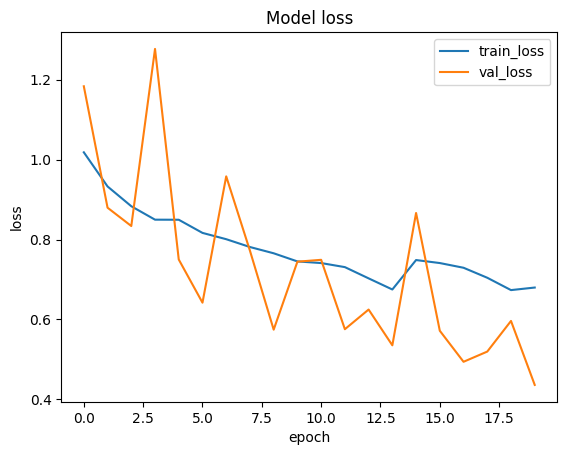

In [219]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [220]:
print(history.history)

{'loss': [1.018109917640686, 0.9327071905136108, 0.8832568526268005, 0.8496412634849548, 0.8494540452957153, 0.8165702223777771, 0.8008115291595459, 0.781258761882782, 0.765579104423523, 0.7452192902565002, 0.7411381006240845, 0.7309770584106445, 0.7028563618659973, 0.6750266551971436, 0.7486668229103088, 0.7411636114120483, 0.7293842434883118, 0.7043857574462891, 0.6735048890113831, 0.6799079775810242], 'accuracy': [0.5121341347694397, 0.5743491649627686, 0.6130313277244568, 0.6364170908927917, 0.6417120099067688, 0.6656861305236816, 0.679217517375946, 0.6936314105987549, 0.7139285206794739, 0.71025151014328, 0.7224591970443726, 0.7356964349746704, 0.7505515813827515, 0.7636417150497437, 0.7211354374885559, 0.7226062417030334, 0.7258420586585999, 0.752022385597229, 0.7726136445999146, 0.7723194360733032], 'top_k_accuracy': [0.79217529296875, 0.841153085231781, 0.8588027358055115, 0.8717458248138428, 0.8776290416717529, 0.8863068222999573, 0.8929254412651062, 0.9014561176300049, 0.9058

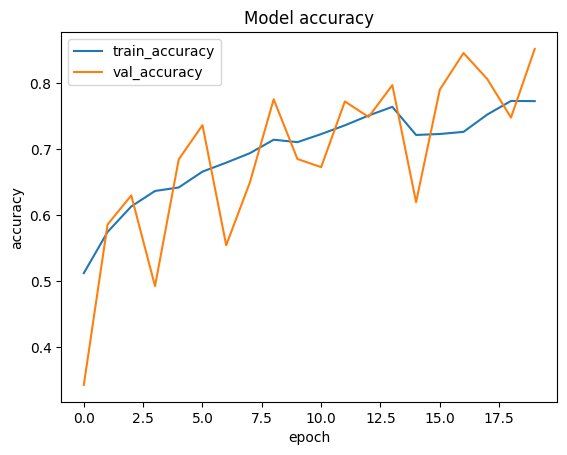

In [221]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

# Model evaluation

In [222]:
lenet_model.evaluate(val_dataset)

213/213 [==============================] - 9s 39ms/step - loss: 0.4364 - accuracy: 0.8513 - top_k_accuracy: 0.9659


[0.436357706785202, 0.8513016700744629, 0.96587735414505]

# Testing

In [223]:
# test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/sad/105639.jpg")

# im = tf.constant(test_image, dtype = tf.float32)

# im = tf.expand_dims(im, axis = 0)

# print(CLASS_NAMES[tf.argmax(lenet_model(im), axis = -1).numpy()[0]])

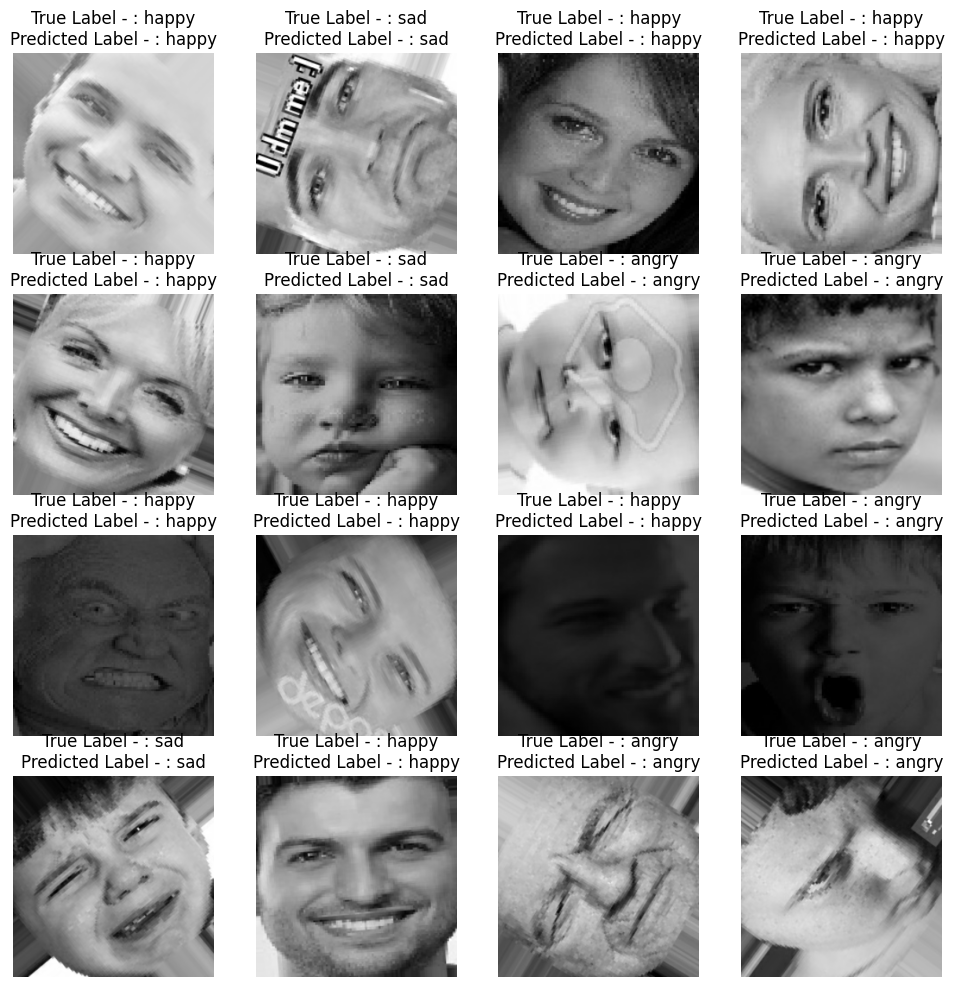

In [224]:
plt.figure(figsize = (12, 12))

for images, labels in val_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(images[i]/255.)
    plt.title("True Label - : " + CLASS_NAMES[tf.argmax(labels[i], axis = 0).numpy()]
              + "\n" + "Predicted Label - : "
              + CLASS_NAMES[tf.argmax(lenet_model(tf.expand_dims(images[i], axis = 0)), axis = -1).numpy()[0]])
    plt.axis("off")

# Confusion Matrix

In [225]:
predicted = []
labels = []

for im, label in val_dataset:
  predicted.append(lenet_model(im))
  labels.append(label.numpy())

In [226]:
print(np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()]))
print(np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()]))

[1 1 1 ... 1 2 1]
[1 1 1 ... 1 2 1]


In [227]:
pred = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])
lab = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])

[[1282  140  103]
 [ 105 2796  118]
 [ 257  288 1710]]


Text(0.5, 58.7222222222222, 'Predicted')

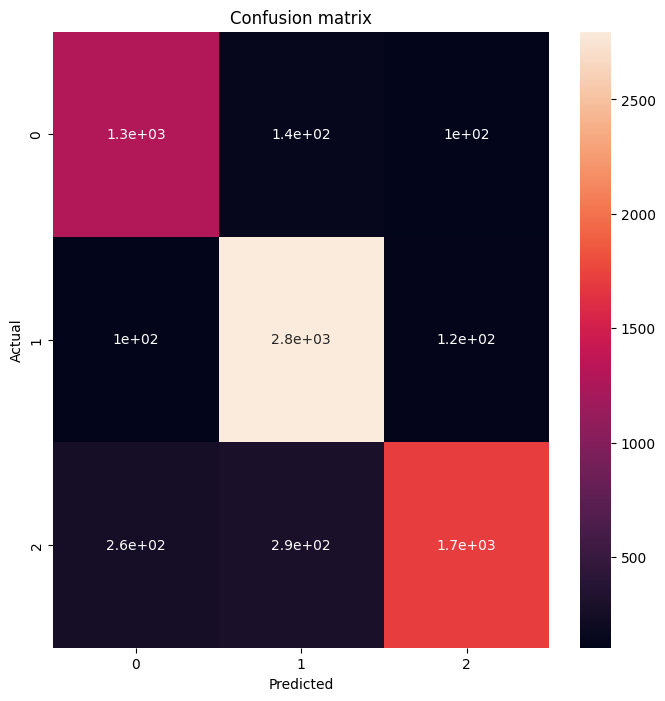

In [228]:
cm = confusion_matrix(lab, pred)
print(cm)

plt.figure(figsize = (8, 8))

sns.heatmap(cm, annot=True,)
plt.title('Confusion matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')